In [3]:
import numpy as np
import os
#import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
# from keras.models import load_model
# from keras.callbacks import EarlyStopping
# from h5py._hl.dataset import sel2

In [4]:
#Functions

def data_to_Input(data):
        
    data_3d = np.array([])
    data_3d = data[np.newaxis,:,:]
    data_3d = data_3d.transpose((1,2,0))
    
    return data_3d

def BP_dat_plot(dat, title):
    dist_data_sbp = dat[:, 0]
    dist_data_dbp = dat[:, 1]

    sbp_mean = np.mean(dist_data_sbp)
    dist_data_sbp = dist_data_sbp.astype(int)

    dbp_mean = np.mean(dist_data_dbp)
    dist_data_dbp = dist_data_dbp.astype(int)

    sbp_std = np.std(dat[:, 0])
    dbp_std = np.std(dat[:, 1])

    fig_bp_dist, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

    axs[0].hist(dist_data_sbp, bins=range(min(dist_data_sbp), max(dist_data_sbp)+2))
    axs[0].set_title(title + ' SBP')
    axs[0].axvline(x=sbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=sbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=sbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlabel('SBP value [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(sbp_mean, sbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(dist_data_dbp, bins=range(min(dist_data_dbp), max(dist_data_dbp)+2))
    axs[1].set_title(title + ' DBP')
    axs[1].axvline(x=dbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=dbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=dbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlabel('DBP value [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(dbp_mean, dbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  
  # absolute error
def error_plot(y_test, y_pred):

    y_test_2d = y_test[:,:,0]
    abs_error_sbp = y_test_2d.T[:,0] - y_pred[:,0]
    abs_error_dbp = y_test_2d.T[:,1] - y_pred[:,1]

    aberr_mean_sbp = np.mean(abs_error_sbp)
    aberr_mean_dbp = np.mean(abs_error_dbp)

    aberr_std_sbp = np.std(abs_error_sbp)
    aberr_std_dbp = np.std(abs_error_dbp)

    abs_error_sbp_int = abs_error_sbp.astype(int)
    abs_error_dbp_int = abs_error_dbp.astype(int)

    fig_abs_error, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(abs_error_sbp_int, bins=range(min(abs_error_sbp_int), max(abs_error_sbp_int)+2))
    axs[0].set_title('BP-CRNN-50 SBP Error')
    axs[0].axvline(x=aberr_mean_sbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp - aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp + aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlim([-10, 60])
    axs[0].set_xlabel('error [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_sbp, aberr_std_sbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(abs_error_dbp_int, bins=range(min(abs_error_dbp_int), max(abs_error_dbp_int)+2))
    axs[1].set_title('BP-CRNN-50 DBP Error')
    axs[1].axvline(x=aberr_mean_dbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp - aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp + aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlim([-20, 20])
    axs[1].set_xlabel('error [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_dbp, aberr_std_dbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  

def bland_altman_plot(data1, data2, *args, **kwargs):
    """
    Bland-Altman plot to compare two sets of measurements.

    Parameters
    ----------
    data1 : array_like
        The first set of measurements.
    data2 : array_like
        The second set of measurements.
    args : positional arguments
        Additional positional arguments to be passed to plt.scatter().
    kwargs : keyword arguments
        Additional keyword arguments to be passed to plt.scatter().

    Returns
    -------
    fig, ax : tuple
        The matplotlib figure and axes objects.
    """
    data1 = data1.T
    data2 = data2.T

    mean = np.mean([data1, data2], axis=0)
    diff = (data1 - data2)
    md = np.mean(diff, axis=1)
    sd = np.std(diff, axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    ax[0].scatter(mean[0], diff[0], *args, **kwargs, alpha = 0.5)
    ax[0].axhline(md[0], color='gray', linestyle='--')
    ax[0].axhline(md[0] + 1.96*sd[0], color='red', linestyle='--')
    ax[0].axhline(md[0] - 1.96*sd[0], color='red', linestyle='--')
    ax[0].set_xlim([data1[0].min(), data1[0].max()])
    ax[0].set_ylim([-50, 50])
    ax[0].set_xlabel('Mean')
    ax[0].set_ylabel('Difference')
    ax[0].set_title('SBP Bland-Altman Plot')

    ax[1].scatter(mean[1], diff[1], *args, **kwargs, alpha = 0.5)
    ax[1].axhline(md[1], color='gray', linestyle='--')
    ax[1].axhline(md[1] + 1.96*sd[1], color='red', linestyle='--')
    ax[1].axhline(md[1] - 1.96*sd[1], color='red', linestyle='--')
    ax[1].set_xlim([data1[1].min(), data1[1].max()])
    ax[1].set_ylim([-50,50])
    ax[1].set_xlabel('Mean')
    ax[1].set_ylabel('Difference')
    ax[1].set_title('DBP Bland-Altman Plot')

    return fig, ax

def pred_plot(test_dat, pred_dat):
    
    sbp_min = test_dat[:, 0].min()
    sbp_max = test_dat[:, 0].max()
    dbp_min = test_dat[:, 1].min()
    dbp_max = test_dat[:, 1].max()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)
    
    ax[0].scatter(test_dat[:,0], pred_dat[:,0], c='red', alpha = 0.5)
    ax[0].set_xlim([sbp_min-10, sbp_max+10])
    ax[0].set_ylim([sbp_min-10, sbp_max+10])
    ax[0].set_xlabel('True SBP')
    ax[0].set_ylabel('Estimated SBP')
    ax[0].set_title('SBP')
    
    ax[1].scatter(test_dat[:,1], pred_dat[:,1], c='red', alpha = 0.5)
    ax[1].set_xlim([dbp_min-10, dbp_max+10])
    ax[1].set_ylim([dbp_min-10, dbp_max+10])
    ax[1].set_xlabel('True DBP')
    ax[1].set_ylabel('Estimated DBP')
    ax[1].set_title('DBP')
    
    return fig, ax

Type dataset root:  D:\김윤철\Dataset\Ex_3\Vitaldb_dataset\Preprocessed\Group_1
Type train size per person:  720


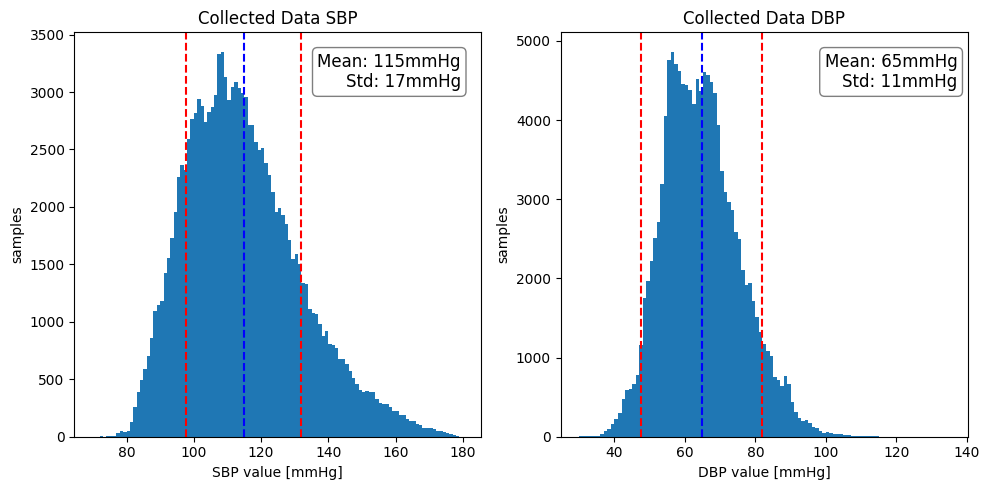

In [4]:
#Train data 부르기
processed_data_dir = input("Type dataset root: ")
train_data_size = int(input("Type train size per person: "))*5/4

total_num = 0
file_list = os.listdir(processed_data_dir)
x_data, y_data = np.empty((0,125)), np.empty((0,2))
for file_name in file_list:
    if file_name.endswith('.npz'):
        data = np.load(processed_data_dir+"//"+file_name)
        x_data = np.concatenate((x_data, data['x']),axis=0)
        y_data = np.concatenate((y_data, data['y']),axis=0)
        total_num += 1
        
x_data = data_to_Input(x_data)        
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size = train_data_size*total_num/x_data.shape[0], test_size = 720*total_num/x_data.shape[0])
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8, test_size = 0.2)

BP_dat_plot(y_data, "Collected Data") 

In [18]:
input_shape = (125, 1)

input = tf.keras.Input(shape = input_shape)
# Batch Normalization for each layers

x1 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(input)

x2 = tf.keras.layers.BatchNormalization()(x1)
x2 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(x2)

x3 = tf.keras.layers.BatchNormalization()(x2)
x3 = tf.keras.layers.Conv1D(filters = 50, kernel_size=7, activation='relu', padding='same')(x3)

concat = tf.keras.layers.Concatenate(axis = 2)([x1, x3])

x4 = tf.keras.layers.BatchNormalization()(concat)
x4 = tf.keras.layers.GRU(25, return_sequences=True, activation='tanh')(x4)
x4 = tf.keras.layers.Flatten()(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(units=64, activation='relu')(x4)

x4 = tf.keras.layers.BatchNormalization()(x4)
x4 = tf.keras.layers.Dense(units=2, activation='relu')(x4)

output = x4

BP_CRNN_Model = tf.keras.Model(inputs = input, outputs = output)

# fit
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
BP_CRNN_Model.compile(opt, loss='mean_squared_error', metrics = ['mae'])
BP_CRNN_Model.reset_states() #가중치 초기화
callback = EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)
hist = BP_CRNN_Model.fit(x_train, y_train, epochs = 1000, batch_size=64, verbose = 2, validation_data = (x_val, y_val), callbacks=[callback])

Epoch 1/1000
563/563 - 19s - loss: 6246.7363 - mae: 72.6539 - val_loss: 3892.3987 - val_mae: 50.9643 - 19s/epoch - 33ms/step
Epoch 2/1000
563/563 - 15s - loss: 3354.0002 - mae: 48.1383 - val_loss: 2465.0044 - val_mae: 40.4423 - 15s/epoch - 27ms/step
Epoch 3/1000
563/563 - 15s - loss: 1399.1421 - mae: 28.2795 - val_loss: 692.7053 - val_mae: 22.2776 - 15s/epoch - 26ms/step
Epoch 4/1000
563/563 - 15s - loss: 193.8283 - mae: 10.0072 - val_loss: 112.6944 - val_mae: 8.0893 - 15s/epoch - 27ms/step
Epoch 5/1000
563/563 - 15s - loss: 109.9970 - mae: 7.9815 - val_loss: 109.2181 - val_mae: 7.9388 - 15s/epoch - 26ms/step
Epoch 6/1000
563/563 - 15s - loss: 103.5082 - mae: 7.7060 - val_loss: 105.1092 - val_mae: 7.8138 - 15s/epoch - 26ms/step
Epoch 7/1000
563/563 - 15s - loss: 96.8246 - mae: 7.4253 - val_loss: 110.7084 - val_mae: 8.0570 - 15s/epoch - 26ms/step
Epoch 8/1000
563/563 - 15s - loss: 90.8717 - mae: 7.1695 - val_loss: 91.5216 - val_mae: 7.1826 - 15s/epoch - 26ms/step
Epoch 9/1000
563/563 - 

In [14]:
# model 저장 (300번 학습)
save_folder_path = input("Type save folder path: ") + "//"
model_name = input("Type model name: ") + ".h5"
BP_CRNN_Model.save(save_folder_path + model_name)

TypeError: 'KerasTensor' object is not callable

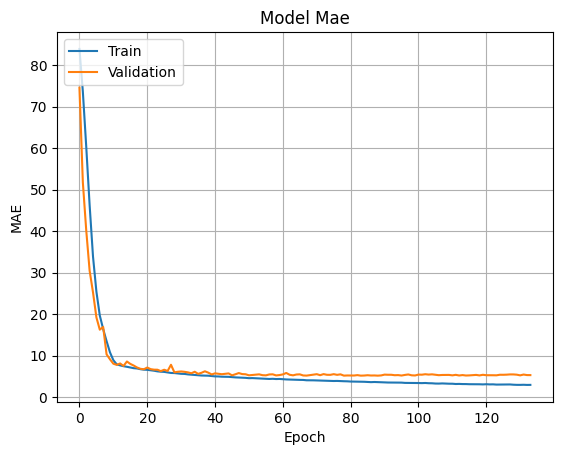

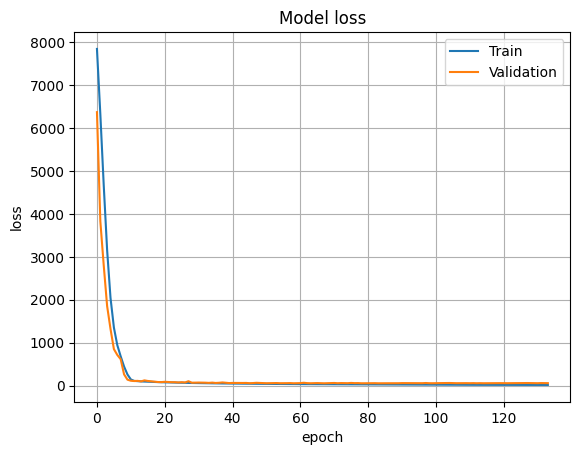

In [7]:
# 학습 기록
plt.plot(hist.history["mae"])
plt.plot(hist.history["val_mae"])
plt.title('Model Mae')
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.grid()
plt.show()

1125/1125 [==============================] - 6s 5ms/step
MAE for SBP: 5.08
MAE for DBP: 2.87


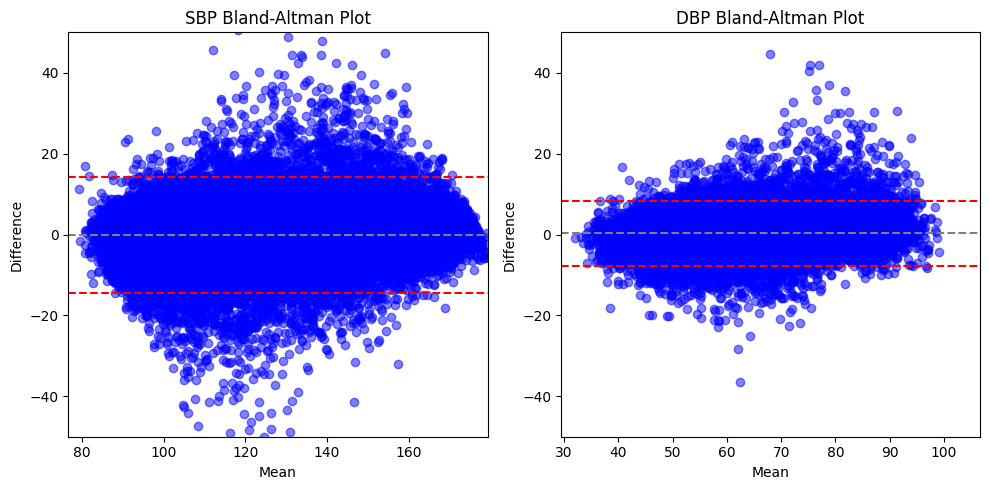

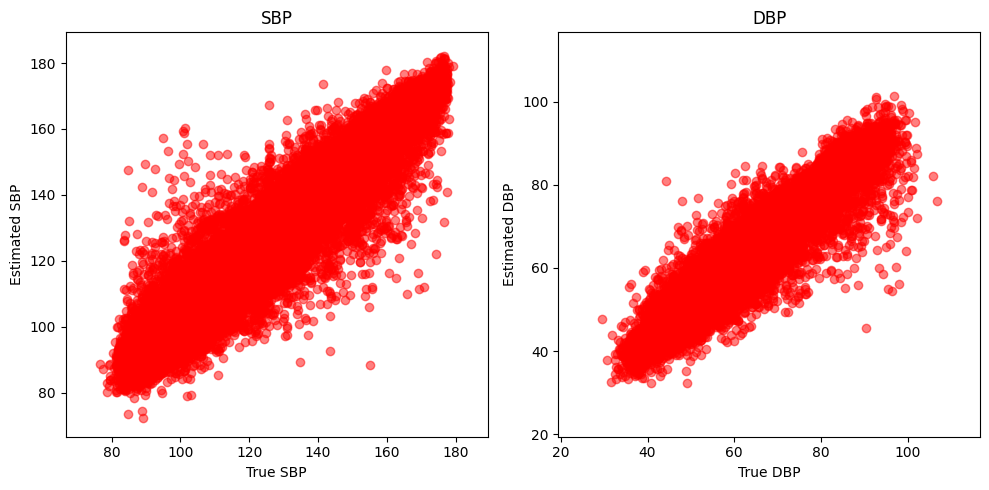

In [7]:
# Predict on test set
y_pred = BP_CRNN_Model.predict(x_test)

print("MAE for SBP: {:.2f}".format(mean_absolute_error(y_test[:,0], y_pred[:,0])))
print("MAE for DBP: {:.2f}".format(mean_absolute_error(y_test[:,1], y_pred[:,1])))

fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, color='blue', marker='o')
fig_ac, ax_ac = pred_plot(y_test, y_pred)

In [8]:
# 재학습을 위해 선행했던 학습모델 불러오기

model = load_model('50_5h_Trained.h5')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss='mean_squared_error', metrics = ['mae'])
callback = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

OSError: No file or directory found at 50_5h_Trained.h5

Text(0.5, 0, 'samples')

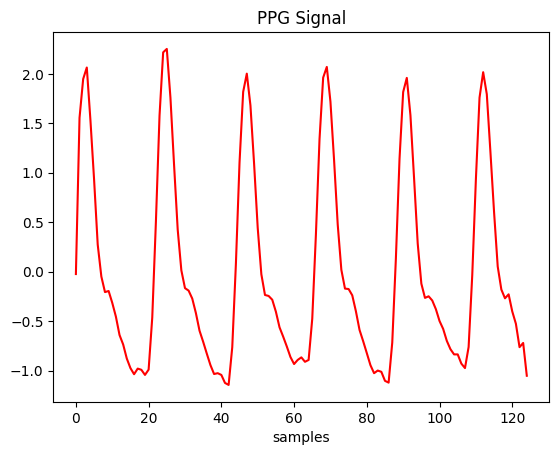

In [74]:
# 수집한 ppg 데이터 시각화

plt.plot(x_train[119, :, 0], color='red')
plt.title("PPG Signal")
plt.xlabel("samples")

Text(0, 0.5, 'MAE(mmHg)')

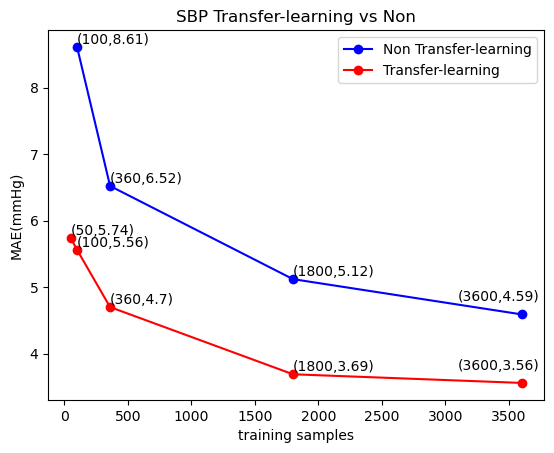

In [6]:
x_1 = [100, 360, 1800, 3600]
x_2 = [50, 100, 360, 1800, 3600]
y_1 = [8.61, 6.52, 5.12, 4.59]
y_2 = [5.74, 5.56, 4.7, 3.69, 3.56]

plt.plot(x_1, y_1, color='blue', label = 'Non Transfer-learning', marker = ".",  markersize=12)
plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.legend()
for i in range(len(x_1)-1):
    plt.annotate('('+str(x_1[i])+','+str(y_1[i])+')', xy=(x_1[i], y_1[i]), xytext=(x_1[i]+1, y_1[i]+0.05))
plt.annotate('('+str(x_1[3])+','+str(y_1[3])+')', xy=(x_1[3], y_1[3]), xytext=(x_1[3]-500, y_1[3]+0.2))

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("SBP Transfer-learning vs Non")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

Text(0, 0.5, 'MAE(mmHg)')

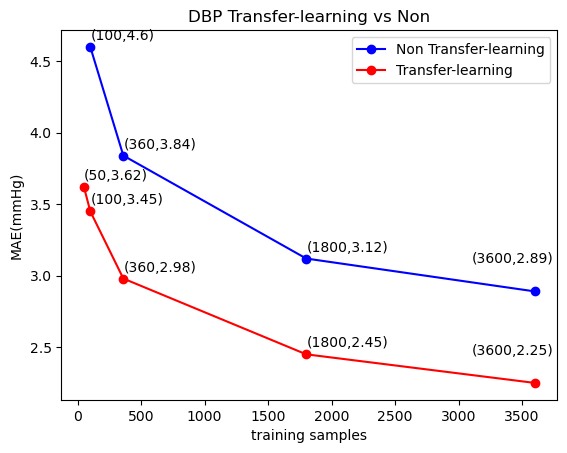

In [5]:
x_1 = [100, 360, 1800, 3600]
x_2 = [50, 100, 360, 1800, 3600]
y_1 = [4.6, 3.84, 3.12, 2.89]
y_2 = [3.62, 3.45, 2.98, 2.45, 2.25]

plt.plot(x_1, y_1, color='blue', label = 'Non Transfer-learning', marker = ".",  markersize=12)
plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.legend()
for i in range(len(x_1)-1):
    plt.annotate('('+str(x_1[i])+','+str(y_1[i])+')', xy=(x_1[i], y_1[i]), xytext=(x_1[i]+1, y_1[i]+0.05))
plt.annotate('('+str(x_1[3])+','+str(y_1[3])+')', xy=(x_1[3], y_1[3]), xytext=(x_1[3]-500, y_1[3]+0.2))

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("DBP Transfer-learning vs Non")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)

Text(0, 0.5, 'MAE(mmHg)')

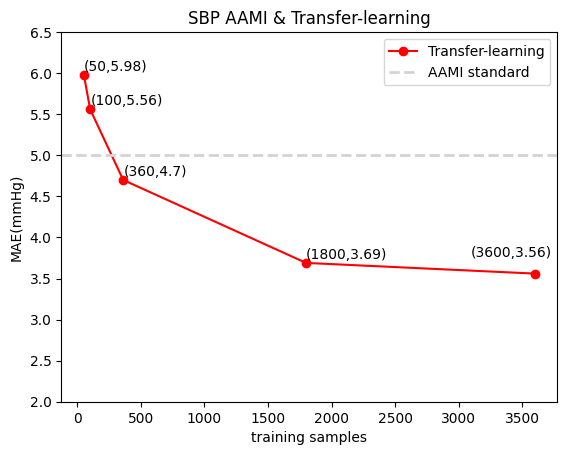

In [24]:
x_2 = [50, 100, 360, 1800, 3600]
y_2 = [5.98, 5.56, 4.7, 3.69, 3.56]

plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.axhline(5.0, color='lightgray', linestyle='--', linewidth=2, label = 'AAMI standard')
plt.ylim(2,6.5)
plt.legend()

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("SBP AAMI & Transfer-learning")
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

Text(0, 0.5, 'MAE(mmHg)')

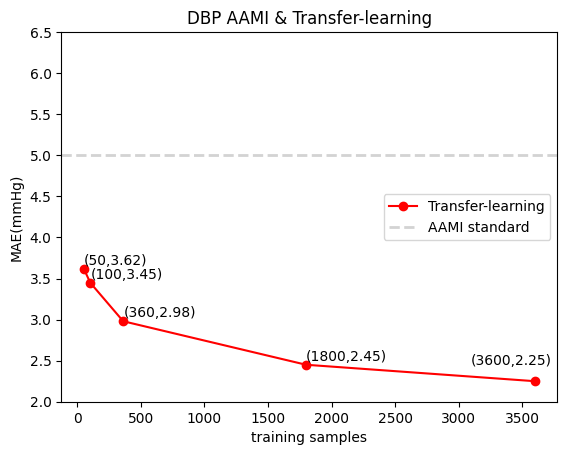

In [21]:
x_2 = [50, 100, 360, 1800, 3600]
y_2 = [3.62, 3.45, 2.98, 2.45, 2.25]

plt.plot(x_2, y_2, color='red', label = 'Transfer-learning', marker = ".",  markersize=12)
plt.axhline(5.0, color='lightgray', linestyle='--', linewidth=2, label = 'AAMI standard')
plt.legend(loc = 'right')

for i in range(len(x_2)-1):
    plt.annotate('('+str(x_2[i])+','+str(y_2[i])+')', xy=(x_2[i], y_2[i]), xytext=(x_2[i]+1, y_2[i]+0.05))
plt.annotate('('+str(x_2[4])+','+str(y_2[4])+')', xy=(x_2[4], y_2[4]), xytext=(x_2[4]-500, y_2[4]+0.2))

plt.title("DBP AAMI & Transfer-learning")
plt.ylim(2,6.5)
plt.xlabel("training samples")
plt.ylabel("MAE(mmHg)")

#plt.annotate(, xy=(x_1[i], y_1[i]), xytext=(2, 4), arrowprops=dict(facecolor='black', arrowstyle='->'),)